# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

You should produce a Jupyter notebook and a `.txt` file (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

Place your notebook and `.txt` files **only** in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 3 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).


## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [1]:
from __future__ import print_function, division
%matplotlib inline
# Your code goes here
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

## Description of the dataset
In this assignment our goal is to recognize objects from 19 dierent visual classes (e.g. person, dog, cat, car, ...) in realistic scenes. The dataset consists of several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

Here we will focus on a single classiffication task: you will be required to classify images as to whether or not they contain a person. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. That is, each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 diffeerent visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image). Our dataset with all images is thus a $N \times 500$ dimensional matrix where `N` is the number of images. The resulting representation is much more compact and can be used directly to perform classiffication.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) correspond to the normalized count vector. The last 19 attributes (`is_class`) indicate the presence of at least one object of a particular class in the image. In most of the experiments (unless explicitly noted otherwise) you will be asked to train classiffiers for classifying person vs. non-person images and only the `is_person` attribute and the 500 dimensional feature vector will be used. Do not use the additional class indicator attributes as features unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

*Important: Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 ==========
Load the datasets `train_images_partA.csv` and `valid_images_partA.csv` into two pandas DataFrame called `train_A` and `valid_A`. Display the number of data points and attributes in each of the two datasets.

In [2]:
# Your code goes here
train_A_loc = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
train_A = pd.read_csv(train_A_loc)
print("In dataset train_A:\nThe number of data points = %d\nThe number of attributes = %d" % (len(train_A.index), len(train_A.columns) - 1))

valid_A_loc = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
valid_A = pd.read_csv(valid_A_loc)
print("In dataset valid_A:\nThe number of data points = %d\nThe number of attributes = %d" % (len(valid_A.index), len(valid_A.columns) - 1))

In dataset train_A:
The number of data points = 2093
The number of attributes = 519
In dataset valid_A:
The number of data points = 1113
The number of attributes = 519


### ========== Question 1.2 ==========
Display and inspect the first 10 instances in the training dataset.

In [3]:
# Your code goes here
train_A.head(10)

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_000008,0.002232,0.000558,0.002790,0.000837,0.001674,0.001953,0.001395,0.002232,0.003627,...,0,0,0,1,0,1,0,0,0,0
1,2008_000015,0.001563,0.000391,0.007422,0.003516,0.003906,0.005078,0.001953,0.002344,0.001953,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0.000521,0.000000,0.000000,0.001042,0.001563,0.005729,0.000521,0.002083,0.003646,...,0,0,1,0,0,0,0,0,0,0
3,2008_000023,0.002976,0.002232,0.004464,0.000372,0.000372,0.002232,0.000000,0.003720,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,2008_000028,0.001359,0.000340,0.001359,0.000340,0.001359,0.002038,0.002378,0.000000,0.003397,...,0,0,0,0,0,0,0,0,0,0
5,2008_000033,0.000000,0.006324,0.000372,0.000372,0.000372,0.000372,0.000744,0.008185,0.000372,...,0,0,0,0,0,0,0,0,0,0
6,2008_000036,0.000340,0.000000,0.004416,0.000340,0.000679,0.006114,0.001359,0.002717,0.003057,...,0,0,0,0,0,1,0,0,0,0
7,2008_000037,0.000837,0.002232,0.000279,0.000279,0.000837,0.000000,0.000279,0.006696,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,2008_000041,0.002378,0.001359,0.004755,0.001019,0.003736,0.001359,0.001019,0.004076,0.003397,...,0,1,0,0,0,1,0,0,0,0
9,2008_000045,0.001019,0.000340,0.006454,0.001698,0.001359,0.003736,0.000000,0.004076,0.000000,...,0,0,0,0,0,0,0,0,0,0


### ========== Question 1.3 ==========
In this part we want to select the appopriate attributes (i.e. input features) for training our classifiers. These should be the attributes `dim1, dim2, ..., dim500`. Create a list which has as elements the **names** of the attributes of interest. 

In [4]:
# Your code goes here
names_attri = list(train_A.columns[1:501])
print(names_attri)

['dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'dim6', 'dim7', 'dim8', 'dim9', 'dim10', 'dim11', 'dim12', 'dim13', 'dim14', 'dim15', 'dim16', 'dim17', 'dim18', 'dim19', 'dim20', 'dim21', 'dim22', 'dim23', 'dim24', 'dim25', 'dim26', 'dim27', 'dim28', 'dim29', 'dim30', 'dim31', 'dim32', 'dim33', 'dim34', 'dim35', 'dim36', 'dim37', 'dim38', 'dim39', 'dim40', 'dim41', 'dim42', 'dim43', 'dim44', 'dim45', 'dim46', 'dim47', 'dim48', 'dim49', 'dim50', 'dim51', 'dim52', 'dim53', 'dim54', 'dim55', 'dim56', 'dim57', 'dim58', 'dim59', 'dim60', 'dim61', 'dim62', 'dim63', 'dim64', 'dim65', 'dim66', 'dim67', 'dim68', 'dim69', 'dim70', 'dim71', 'dim72', 'dim73', 'dim74', 'dim75', 'dim76', 'dim77', 'dim78', 'dim79', 'dim80', 'dim81', 'dim82', 'dim83', 'dim84', 'dim85', 'dim86', 'dim87', 'dim88', 'dim89', 'dim90', 'dim91', 'dim92', 'dim93', 'dim94', 'dim95', 'dim96', 'dim97', 'dim98', 'dim99', 'dim100', 'dim101', 'dim102', 'dim103', 'dim104', 'dim105', 'dim106', 'dim107', 'dim108', 'dim109', 'dim110', 'dim111

### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` and store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets (also make sure you do not include this attribute in your training features). Display the dimensionalities (i.e shapes) of the 4 arrays and make sure your input data are 500-dimensional.

In [5]:
# Your code goes here
X_tr = train_A[names_attri]
X_val = valid_A[names_attri]
y_tr = train_A['is_person']
y_val = valid_A['is_person']

print("The dimensionalities of the training features:{}\nThe dimensionalities of the validation features:{}\nThe dimensionalities of the training targets:{}\nThe dimensionalities of the validation targets:{}"
      .format(X_tr.shape, X_val.shape, y_tr.shape, y_val.shape))

The dimensionalities of the training features:(2093, 500)
The dimensionalities of the validation features:(1113, 500)
The dimensionalities of the training targets:(2093,)
The dimensionalities of the validation targets:(1113,)


### ========== Question 1.5 ==========
Show two [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) of the targets in a single plot, one for the training and one for the validation set. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

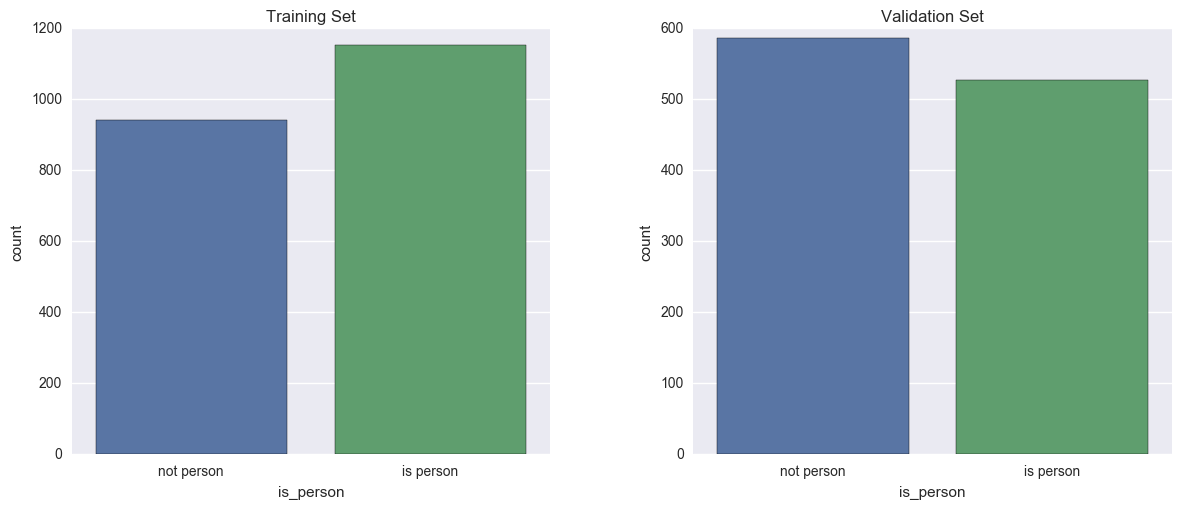

In [6]:
# Your code goes here
labels = ['not person','is person']
plt.figure()
plt.subplot(1,2,1)
ax = sns.countplot(x = y_tr, data = y_tr)
ax.set_xticklabels(labels)
plt.title('Training Set')

plt.subplot(1,2,2)
ax = sns.countplot(x = 'is_person', data = valid_A)
ax.set_xticklabels(labels)
plt.title('Validation Set')
plt.subplots_adjust(wspace = 0.3, right = 1.5)
plt.show()

### ========== Question 1.6 ==========
What would be a good choice for a baseline classifier to compare your results in the next steps against? What classification accuracy score does the baseline classifier achieve in the validation set?

*Your answer goes here*  
1.  I chose the baseline classifier which is whatever the features are, just predict every targets are 1.  
2.  The classification accuracy score of baseline classifier in the validation set is 0.473495058401


In [7]:
# Your code goes here
def baseline(features, targets):
    return 1
def blpredict(baseline, features):
    pre = pd.Series()
    for row in range(len(features.index)):
        pre.set_value(row, baseline)
    return pre
bl = baseline(X_tr, y_tr)
pre = blpredict(bl, X_val)
accuracy_baseline = accuracy_score(y_val, pre)
print("The baseline performance = %.12f" % accuracy_baseline)

The baseline performance = 0.473495058401


### ========== Question 1.7 ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier by using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score in the training and validation sets and compare to that of the baseline classifier. Comment in 1-2 sentences the results. You may include any additional plot(s) if you wish to justify your explanation.

In [8]:
# Your code goes here
lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_tr, y_tr)
accuracy_tr = lr.score(X_tr, y_tr)
accuracy_val = lr.score(X_val, y_val)
print(" classification accuracy score in the training sets = {}\n classification accuracy score in the validation sets = {}".format(accuracy_tr, accuracy_val))

 classification accuracy score in the training sets = 0.55088389871
 classification accuracy score in the validation sets = 0.526504941599


*Your answer goes here*  
1. The classification accuracy score in the training sets is 0.55088389871 and the classification accuracy score in the validation sets is 0.526504941599. Both of them are higher than which baseline classifier achieves.
2. I think classification calculation is very small, very fast, low storage resources. But in dealing with a large number of multi-class features or variables, the accuracy is low and easy to under-fitting

 

### ========== Question 1.8 ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [9]:
# Your code goes here
np.set_printoptions(precision=3)
features_5_mean = []
features_5_std = []
for n in range(5):
    features_5_mean.append(X_tr.iloc[:,n].mean())
    features_5_std.append(X_tr.iloc[:,n].std())

print("means of the first 5 features in the training set:{}\n\nstandard deviations of the first 5 features in the training set:{}".format(features_5_mean, features_5_std))

means of the first 5 features in the training set:[0.0017505776397515665, 0.0007559225991399952, 0.004316947921643566, 0.0018527792642140607, 0.002272475394171055]

standard deviations of the first 5 features in the training set:[0.0011930946342307437, 0.0014063713684971735, 0.003693435646445931, 0.0013404915150502222, 0.001598113642137162]


### ========== Question 1.9 ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers an [implementation](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) of feature standardisation. Create a standardiser and fit it by using training features only. Then transform both your input and validation input features. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. 

**IMPORTANT: You should use the transformed data for the rest of part A**.

In [10]:
# Your code goes here
ss = StandardScaler()
ss.fit(X_tr)
X_tr_T = ss.transform(X_tr)
X_val_T = ss.transform(X_val)

features_tr_5_mean = []
features_tr_5_std = []
features_val_5_mean = []
features_val_5_std = []
for n in range(5):
    features_tr_5_mean.append(X_tr_T[:,n].mean())
for n in range(5):
    features_tr_5_std.append(X_tr_T[:,n].std())
for n in range(5):
    features_val_5_mean.append(X_val_T[:,n].mean())
for n in range(5):
    features_val_5_std.append(X_val_T[:,n].std())

print("means of the first 5 features in the training set:{}\n\nstandard deviations of the first 5 features in the training set:{}\n".format(features_tr_5_mean, features_tr_5_std))
print("means of the first 5 features in the validation set:{}\n\nstandard deviations of the first 5 features in the validation set:{}".format(features_val_5_mean, features_val_5_std))

means of the first 5 features in the training set:[-3.3948530136650752e-17, -2.2066544588822986e-17, 2.444294169838854e-16, 1.4258382657393315e-16, -5.771250123230628e-17]

standard deviations of the first 5 features in the training set:[1.0, 0.99999999999999989, 0.99999999999999989, 1.0, 1.0]

means of the first 5 features in the validation set:[-0.0055061232432523418, -0.038293302010467635, 0.10915097659348594, 0.093693139057151278, 0.030578437247359185]

standard deviations of the first 5 features in the validation set:[1.0131088625998594, 0.96981949256252276, 1.0492284982818851, 1.0568447881544516, 0.97471336291900057]


*Your answer goes here*  
1. The results are as I expected
2. Because the standardization of datasets make indivitual features more look like standard normally distributed. This implement makes the value of the feature less than 1, then scale it by dividing non-constant features by their standard deviation. At the same time, some features of the large number of variance to the average level of variance.


### ========== Question 1.10 ==========
By using the transformed input data, retrain a `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy in both the training and validation sets. How does your model compare to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

In [11]:
# Your code goes here
lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_tr_T, y_tr)
accuracy_tr = lr.score(X_tr_T, y_tr)
accuracy_val = lr.score(X_val_T, y_val)
print(" classification accuracy score in the training sets = {}\n classification accuracy score in the validation sets = {}".format(accuracy_tr, accuracy_val))

 classification accuracy score in the training sets = 0.810797897754
 classification accuracy score in the validation sets = 0.643306379155


*Your answer goes here*  
1. the classification accuracy score in the training sets is 0.810797897754
 the classification accuracy score in the validation sets is 0.643306379155.
2. By using the transformed input data, the logisticregression classifier performs more better than before and baseline classifier.



### ========== Question 1.11 ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes for the weight vector. Thus, it helps us prevent overfitting and, for logistic regression, it additionally controls the level of confidence in making predictions.

We would like to optimise this parameter **by using the transformed training dataset only** and not the validation set. Create a 3-fold cross-validation object for the training dataset. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples in each iteration fold.

In [12]:
# Your code goes here
kf = KFold(len(X_tr_T), n_folds=3, shuffle = True, random_state = 0)
print("the number of test samples in each iteration fold:")
for train_index, test_index in kf:
    num_test = len(test_index)
    print(num_test)

the number of test samples in each iteration fold:
698
698
697


### ========== Question 1.12 ========== 
Now we want to test out different settings for the regularisation parameter `C` by using the cross-validation iterator from the previous question. For each iteration, we want to train multiple classifiers by using a range of values for `C` and then compute the performance within each CV fold. You should use a log-range for `C` from `1e-5` to `1e5` by using 20 equally-spaced values *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters.

*(hint: your may want to use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [13]:
# Your code goes here
c = np.logspace(-5, 5, num=20, endpoint = True, base = 10)
score_array = [[0] * 20 for row in range(3)]
count = 0
for train_index, test_index in kf:
    x_train, x_test = X_tr_T[train_index], X_tr_T[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
    for n in range(len(c)):
        lr = LogisticRegression(C = c[n], solver = 'lbfgs')
        fit_tr = lr.fit(x_train, y_train)
        score_array[count][n] = fit_tr.score(x_test, y_test)
    count += 1

### ========== Question 1.13 ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

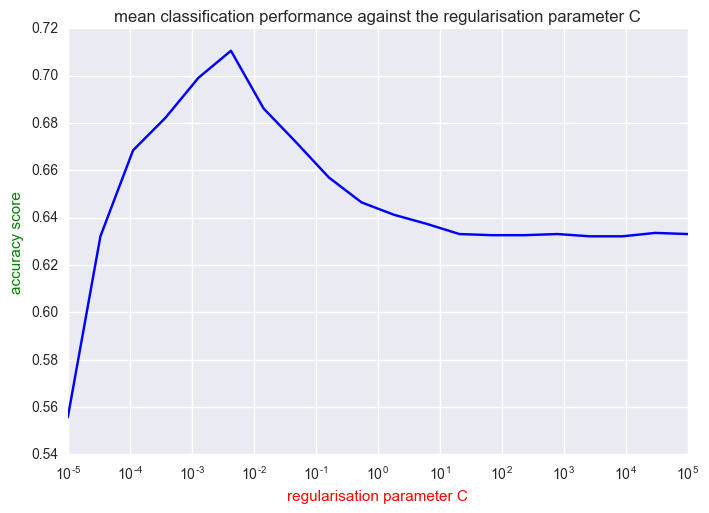

In [14]:
# Your code goes here
score_array_mean = [0.0] * 20
for row in range(3):
    for column in range(len(score_array[0])):
        score_array_mean[column] += score_array[row][column]
for n in range(len(score_array_mean)):
    score_array_mean[n] /= 3

plt.figure()
plt.semilogx(c, score_array_mean, basex=10, color='blue')
plt.xlabel('regularisation parameter C', color = 'red')
plt.ylabel('accuracy score', color = 'green')
plt.title('mean classification performance against the regularisation parameter C')
plt.grid(True)
plt.show()

### ========== Question 1.14 ==========
Find and display the optimal value for the regularisation parameter `C` of the logistic classifier by using your results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [15]:
# Your code goes here
highest_average = np.amax(score_array_mean)
optimal_value = 0.0
for n in range(len(score_array_mean)):
    if score_array_mean[n] == highest_average:
        optimal_value = n
optimal_value = c[optimal_value]
lr = LogisticRegression(C = optimal_value, solver = 'lbfgs')
lr.fit(X_tr_T, y_tr)
accuracy_score = lr.score(X_val_T, y_val)
print("classification accuracy on the validation set by using the optimal value of the parameter C({}) = {}".format(optimal_value,accuracy_score))

classification accuracy on the validation set by using the optimal value of the parameter C(0.00428133239872) = 0.696316262354


### ========== Question 1.15 ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Can you verify that your results are consistent with those from Question 1.14?

In [16]:
# Your code goes here
lrcv = LogisticRegressionCV(Cs = c, cv = kf, solver = 'lbfgs')
lrcv.fit(X_tr_T, y_tr)
optimal_value2 = lrcv.C_
accuracy_score = fit_tr.score(X_val_T, y_val)
print("classification accuracy on the validation set by using the optimal value of the parameter C({}) = {}".format(optimal_value2[0],accuracy_score))


classification accuracy on the validation set by using the optimal value of the parameter C(0.00428133239872) = 0.640610961366


### ========== Question 1.16 ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to Lab_3 if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 31 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [17]:
# Your code goes here
rf = RandomForestClassifier(n_estimators = 500, random_state = 31)
fit_rf = rf.fit(X_tr_T, y_tr)
accuracy_score1 = fit_rf.score(X_tr_T, y_tr)
accuracy_score2 = fit_rf.score(X_val_T, y_val)
print(" classification accuracy score in the training sets = {}\n classification accuracy score in the validation sets = {}".format(accuracy_score1, accuracy_score2))

 classification accuracy score in the training sets = 1.0
 classification accuracy score in the validation sets = 0.700808625337


### ========== Question 1.17 ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

*Your answer goes here*  
Yes, I think the classification accuracy score in the training set is 1.0 and it is too perfect and the distance between training and validation accuracies is far. So the training model may be overfitting.


### ========== Question 1.18 ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [18]:
# Your code goes here
important_features_50 = [] * 50
temp = sorted(zip(map(lambda X_tr_T: round(X_tr_T, 4), rf.feature_importances_), names_attri), reverse=True)[0:50]
for f50 in temp:
    important_features_50.append(f50[1])
print("names of the 50 most important features:\n",format(important_features_50))


names of the 50 most important features:
 ['dim21', 'dim479', 'dim360', 'dim283', 'dim76', 'dim51', 'dim4', 'dim461', 'dim330', 'dim398', 'dim343', 'dim222', 'dim274', 'dim485', 'dim423', 'dim217', 'dim356', 'dim263', 'dim74', 'dim347', 'dim214', 'dim500', 'dim329', 'dim92', 'dim54', 'dim326', 'dim90', 'dim348', 'dim483', 'dim312', 'dim25', 'dim154', 'dim77', 'dim289', 'dim134', 'dim73', 'dim427', 'dim288', 'dim254', 'dim440', 'dim353', 'dim322', 'dim17', 'dim206', 'dim96', 'dim85', 'dim442', 'dim171', 'dim35', 'dim48']


### ========== Question 1.19 ==========
Next, we would like to test out the performance of support vector classification and experiment with different kernels. 
By using training data only and default parameter settings, train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [19]:
# Your code goes here
svc_linear = LinearSVC()
svc_linear.fit(X_tr_T, y_tr)
print('Linear SVC classification accuracy on training set: {:.3f}'.format(svc_linear.score(X_tr_T, y_tr)))
print('Linear SVC classification accuracy on test set: {:.3f}'.format(svc_linear.score(X_val_T, y_val)))
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(X_tr_T, y_tr)
svc_poly = SVC(kernel='poly')
svc_poly.fit(X_tr_T, y_tr)
print('RBF SVC classification accuracy on training set: {:.3f}'.format(svc_rbf.score(X_tr_T, y_tr)))
print('RBF SVC classification accuracy on validation set: {:.3f}'.format(svc_rbf.score(X_val_T, y_val)))
print('Poly SVC classification accuracy on training set: {:.3f}'.format(svc_poly.score(X_tr_T, y_tr)))
print('Poly SVC classification accuracy on validation set: {:.3f}'.format(svc_poly.score(X_val_T, y_val)))

Linear SVC classification accuracy on training set: 0.792
Linear SVC classification accuracy on test set: 0.652
RBF SVC classification accuracy on training set: 0.911
RBF SVC classification accuracy on validation set: 0.730
Poly SVC classification accuracy on training set: 0.991
Poly SVC classification accuracy on validation set: 0.702


### ========== Question 1.20 ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the results by using 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [20]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

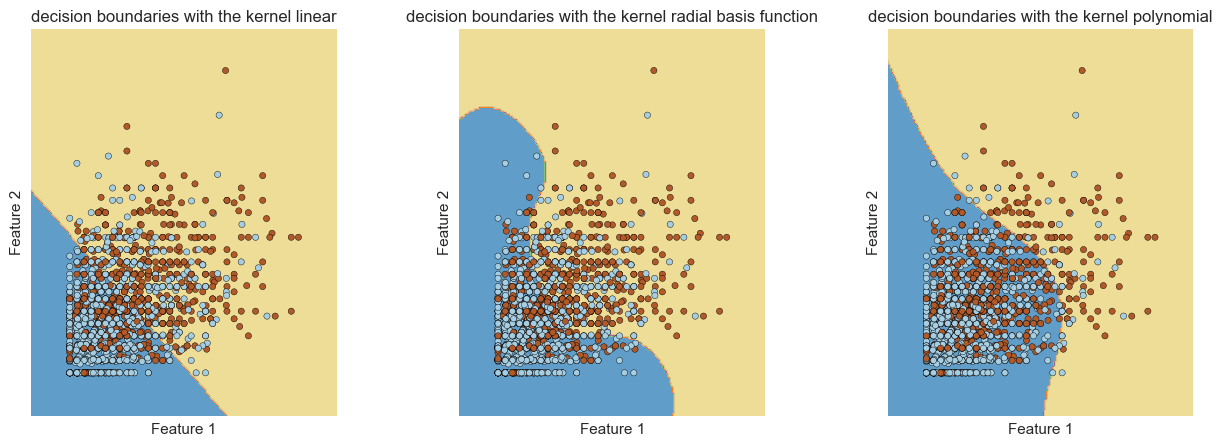

In [21]:
# Your code goes here
X_tr_T1 = X_tr_T
X_tr_T1 = np.delete(X_tr_T1, np.s_[76:500], axis  = 1)
X_tr_T1 = np.delete(X_tr_T1, np.s_[21:75], axis  = 1)
X_tr_T1 = np.delete(X_tr_T1, np.s_[0:20], axis  = 1)

svc_linear = LinearSVC()
svc_linear.fit(X_tr_T1, y_tr)
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(X_tr_T1, y_tr)
svc_poly = SVC(kernel='poly')
svc_poly.fit(X_tr_T1, y_tr)
clfs = [svc_linear, svc_rbf, svc_poly]
show_svc_decision_boundaries(clfs = clfs, X = X_tr_T1, title=['decision boundaries with the kernel linear','decision boundaries with the kernel radial basis function','decision boundaries with the kernel polynomial'])
plt.show()

*Your answer goes here*  
According to the graphs above, we can see the linear kernal will produce a linear decision boundary, but other two non-linear kernals will produce flexible non-linear decision boundaries.



### ========== Question 1.21 ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

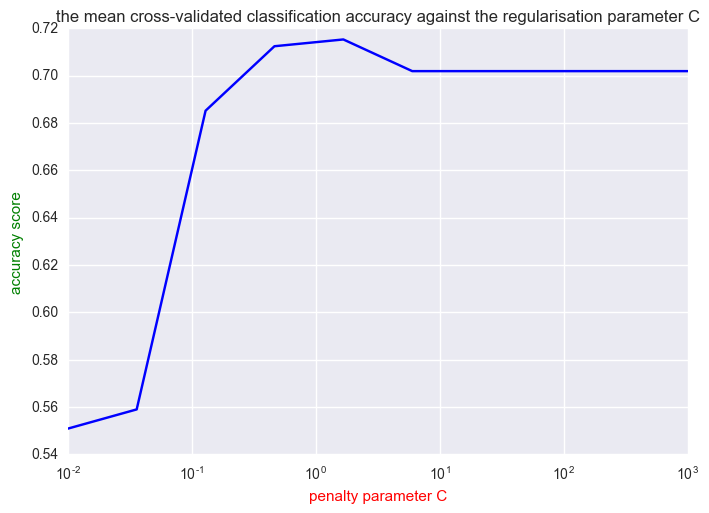

the highest obtained mean accuracy score = 0.715230644637
and the value of C which yielded it = 1.6681005372
RBF SVC classification accuracy on training set: 0.975
RBF SVC classification accuracy on validation set: 0.728


In [22]:
# Your code goes here
# estimate the classification accuracy of an SVM classifier with RBF kernel
# while you vary the penalty parameter C in a logarithmic range np.logspace(-2, 3, 10).
penalty_c = np.logspace(-2, 3, 10)
score_array = [[0] * 10 for row in range(3)]
count = 0
# By using the K-fold iterator 
for train_index, test_index in kf:
    x_train, x_test = X_tr_T[train_index], X_tr_T[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
    for n in range(len(penalty_c)):
        svc_rbf = SVC(C = penalty_c[n], kernel='rbf', gamma = 'auto')
        svc_rbf.fit(x_train, y_train)
        score_array[count][n] = svc_rbf.score(x_test, y_test)
    count += 1
# Plot the mean cross-validated classification accuracy against the regularisation parameter C by using a log-scale for the x-axis.
score_array_mean = [0.0] * 10
for row in range(3):
    for column in range(len(score_array[0])):
        score_array_mean[column] += score_array[row][column]
for n in range(len(score_array_mean)):
    score_array_mean[n] /= 3

plt.figure()
plt.semilogx(penalty_c, score_array_mean, basex=10, color='blue')
plt.xlabel('penalty parameter C', color = 'red')
plt.ylabel('accuracy score', color = 'green')
plt.title('the mean cross-validated classification accuracy against the regularisation parameter C')
plt.grid(True)
plt.show()
# Display the highest obtained mean accuracy score and the value of C which yielded it. Label axes appropriately.
highest_average = np.amax(score_array_mean)
optimal_value = 0.0
for n in range(len(score_array_mean)):
    if score_array_mean[n] == highest_average:
        optimal_value = n
optimal_value = penalty_c[optimal_value]
print("the highest obtained mean accuracy score = {}\nand the value of C which yielded it = {}".format(highest_average, optimal_value))

# Finally, train a classifier by using the optimal value for this parameter
svc_rbf = SVC(C = optimal_value, kernel='rbf', gamma = 'auto')
svc_rbf.fit(X_tr_T, y_tr)
print('RBF SVC classification accuracy on training set: {:.3f}'.format(svc_rbf.score(X_tr_T, y_tr)))
print('RBF SVC classification accuracy on validation set: {:.3f}'.format(svc_rbf.score(X_val_T, y_val)))

### ========== Question 1.22 ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

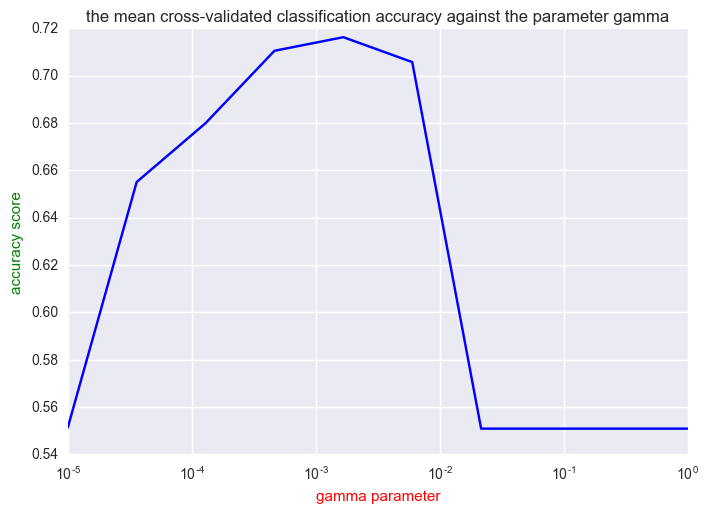

the highest obtained mean accuracy score = 0.716185754475
and the value of gamma which yielded it = 0.0016681005372
RBF SVC classification accuracy on training set: 0.891
RBF SVC classification accuracy on validation set: 0.727


In [23]:
# Your code goes here
# estimate the classification accuracy of an SVM classifier with RBF kernel
# while you vary the gamma parameter in a logarithmic range logspace(-5, 0, 10).
gamma = np.logspace(-5, 0, 10)
penalty_c = 1.0
score_array = [[0] * 10 for row in range(3)]
count = 0
# By using the K-fold iterator 
for train_index, test_index in kf:
    x_train, x_test = X_tr_T[train_index], X_tr_T[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
    for n in range(len(gamma)):
        svc_rbf = SVC(C = penalty_c, kernel='rbf', gamma = gamma[n])
        svc_rbf.fit(x_train, y_train)
        score_array[count][n] = svc_rbf.score(x_test, y_test)
    count += 1
# Plot the mean cross-validated classification accuracy against the regularisation parameter C by using a log-scale for the x-axis.
score_array_mean = [0.0] * 10
for row in range(3):
    for column in range(len(score_array[0])):
        score_array_mean[column] += score_array[row][column]
for n in range(len(score_array_mean)):
    score_array_mean[n] /= 3

plt.figure()
plt.semilogx(gamma, score_array_mean, basex=10, color='blue')
plt.xlabel('gamma parameter', color = 'red')
plt.ylabel('accuracy score', color = 'green')
plt.title('the mean cross-validated classification accuracy against the parameter gamma')
plt.grid(True)
plt.show()
# Display the highest obtained mean accuracy score and the value of C which yielded it. Label axes appropriately.
highest_average = np.amax(score_array_mean)
optimal_value = 0.0
for n in range(len(score_array_mean)):
    if score_array_mean[n] == highest_average:
        optimal_value = n
optimal_value = gamma[optimal_value]
print("the highest obtained mean accuracy score = {}\nand the value of gamma which yielded it = {}".format(highest_average, optimal_value))

# Finally, train a classifier by using the optimal value for this parameter
svc_rbf = SVC(C = penalty_c, kernel='rbf', gamma = optimal_value)
svc_rbf.fit(X_tr_T, y_tr)
print('RBF SVC classification accuracy on training set: {:.3f}'.format(svc_rbf.score(X_tr_T, y_tr)))
print('RBF SVC classification accuracy on validation set: {:.3f}'.format(svc_rbf.score(X_val_T, y_val)))

### ========== Question 1.23 ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

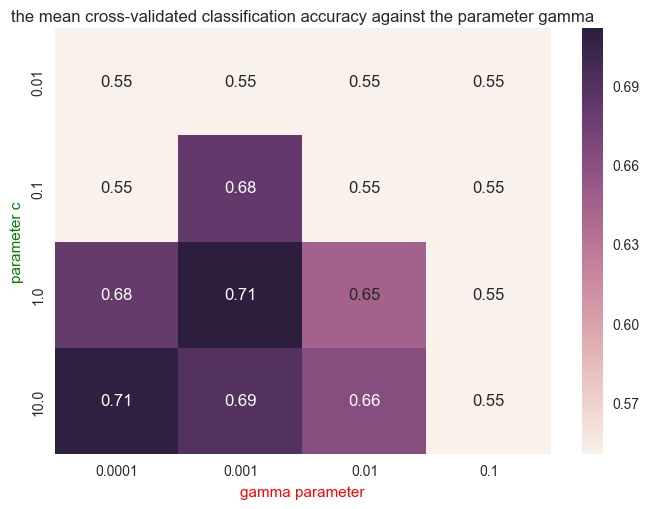

the values for C for the best performing configuration = 1.0
the values for gamma for the best performing configuration = 0.001
RBF SVC classification accuracy on training set: 0.835
RBF SVC classification accuracy on validation set: 0.721


In [24]:
# Your code goes here 
# estimate the classification accuracy of an SVM classifier with RBF kernel
# while you vary the gamma parameter in a logarithmic range logspace(-5, 0, 10).
gamma = np.logspace(-4, -1, 4)
penalty_c = np.logspace(-2, 1, 4)
grid = [[0] * 4 for row in range(4)]
for i in range(len(penalty_c)):
    for j in range(len(gamma)):
        grid[i][j] = (penalty_c[i], gamma[j])
score_array = [[0] * 16 for row in range(3)]
count = 0
# By using the K-fold iterator
for train_index, test_index in kf:
    x_train, x_test = X_tr_T[train_index], X_tr_T[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
    flag = 0
    for i in range(4):
        for j in range(4):
            svc_rbf = SVC(C = grid[i][j][0], kernel='rbf', gamma = grid[i][j][1])
            svc_rbf.fit(x_train, y_train)
            score_array[count][flag] = svc_rbf.score(x_test, y_test)
            flag += 1
    count += 1
# Plot the mean cross-validated classification accuracy against the regularisation parameter C by using a log-scale for the x-axis.
score_array_mean = [0.0] * 16
for row in range(3):
    for column in range(len(score_array[0])):
        score_array_mean[column] += score_array[row][column]
for n in range(len(score_array_mean)):
    score_array_mean[n] /= 3
grid_score = [[0] * 4 for row in range(4)]
count = 0
for i in range(len(penalty_c)):
    for j in range(len(gamma)):
        grid_score[i][j] = score_array_mean[count]
        count += 1

df = pd.DataFrame(grid_score, index = penalty_c, columns = gamma)
plt.figure()
ax = sns.heatmap(df, annot = True)
plt.xlabel('gamma parameter', color = 'red')
plt.ylabel('parameter c', color = 'green')
plt.title('the mean cross-validated classification accuracy against the parameter gamma')
plt.grid(True)
plt.show()
# Display the highest obtained mean accuracy score and the value of C which yielded it. Label axes appropriately.
highest_average = np.amax(score_array_mean)
optimal_value = 0.0
for i in range(len(penalty_c)):
    for j in range(len(gamma)):
        if grid_score[i][j] == highest_average:
            optimal_value = grid[i][j]
optimal_c = optimal_value[0]
optimal_gamma = optimal_value[1]
print("the values for C for the best performing configuration = {}\nthe values for gamma for the best performing configuration = {}".format(optimal_c, optimal_gamma))

# Finally, train a classifier by using the optimal value for this parameter
svc_rbf = SVC(C = optimal_c, kernel='rbf', gamma = optimal_gamma)
svc_rbf.fit(X_tr_T, y_tr)
print('RBF SVC classification accuracy on training set: {:.3f}'.format(svc_rbf.score(X_tr_T, y_tr)))
print('RBF SVC classification accuracy on validation set: {:.3f}'.format(svc_rbf.score(X_val_T, y_val)))

### ========== Question 1.24 ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

*Your answer goes here*  
1. No it is not higher than in previous questions.
2. I think even 1.23 used the best performence parameteors pair in 16 situations. But there are more better parameteors pair within the range of 2 parameters.
3. Nearing the range of the best-performing pair of parameters reduced range of the search and find the better pair of parameters.
4. Time overhead, but to enhance the performance will be less and less。



### ========== Question 1.25 ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

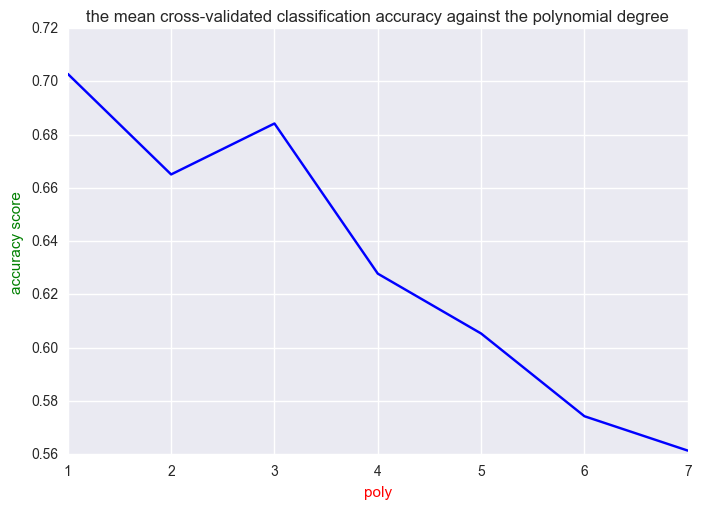

the highest obtained mean accuracy score = 0.702810105802
and the value of gamma which yielded it = 1
Poly SVC classification accuracy on training set: 0.784
Poly SVC classification accuracy on validation set: 0.689


In [25]:
# Your code goes here
# evaluate the performance of an SVM classifier with polynomial kernel
degree = np.arange(1,8)
score_array = [[0] * 7 for row in range(3)]
count = 0
# By using the K-fold iterator 
for train_index, test_index in kf:
    x_train, x_test = X_tr_T[train_index], X_tr_T[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
    for n in range(len(degree)):
        svc_poly = SVC(degree = degree[n], kernel='poly')
        svc_poly.fit(x_train, y_train)
        score_array[count][n] = svc_poly.score(x_test, y_test)
    count += 1
# Plot the mean cross-validated classification accuracy against the regularisation parameter C by using a log-scale for the x-axis.
score_array_mean = [0.0] * 7
for row in range(3):
    for column in range(len(score_array[0])):
        score_array_mean[column] += score_array[row][column]
for n in range(len(score_array_mean)):
    score_array_mean[n] /= 3

plt.figure()
plt.plot(degree, score_array_mean, color='blue')
plt.xlabel('poly', color = 'red')
plt.ylabel('accuracy score', color = 'green')
plt.title('the mean cross-validated classification accuracy against the polynomial degree')
plt.grid(True)
plt.show()
# Display the highest obtained mean accuracy score and the value of C which yielded it. Label axes appropriately.
highest_average = np.amax(score_array_mean)
optimal_value = 0.0
for n in range(len(score_array_mean)):
    if score_array_mean[n] == highest_average:
        optimal_value = n
optimal_value = degree[optimal_value]
print("the highest obtained mean accuracy score = {}\nand the value of gamma which yielded it = {}".format(highest_average, optimal_value))

# Finally, train a classifier by using the optimal value for this parameter
svc_poly = SVC(degree = optimal_value, kernel='poly')
svc_poly.fit(X_tr_T, y_tr)
print('Poly SVC classification accuracy on training set: {:.3f}'.format(svc_poly.score(X_tr_T, y_tr)))
print('Poly SVC classification accuracy on validation set: {:.3f}'.format(svc_poly.score(X_val_T, y_val)))

### ========== Question 1.26 ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

*Your answer goes here*
1. Because the random distribution of the cross validation can effectively use each data, and that all of them can serve as a train as a test, the training effect is better.
2. As for hold-out validation, when a small data set is used to train the model in hold-out validation way and then predict on a large data set, it will be significantly different from the true value. But save more time.
  As for cross validation, the disadvantage is that it takes more time. But training effect is better.
3. I would trust cross validation more in practice.

### ========== Question 1.27 ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [26]:
# Your code goes here
# Reload the full training and validation data that contain all indicator variables for all object categories
train_A_loc = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
train_A = pd.read_csv(train_A_loc)

valid_A_loc = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
valid_A = pd.read_csv(valid_A_loc)


names_attri = list(train_A.columns[1:515])
for attri in list(train_A.columns[516:520]):
    names_attri.append(attri)

X_tr = train_A[names_attri]
X_val = valid_A[names_attri]
y_tr = train_A['is_person']
y_val = valid_A['is_person']

# use a StandardScaler to standardise your training and validation features
ss = StandardScaler()
ss.fit(X_tr)
X_tr_T = ss.transform(X_tr)
X_val_T = ss.transform(X_val)

# train a Random Forest Classifier by using the entropy criterion, 500 n_estimators, and also set the random_state to 31. 
# Report the classification accuracy on the training and validation sets.
rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 500, random_state = 31)
fit_rf = rf.fit(X_tr_T, y_tr)
accuracy_score1 = fit_rf.score(X_tr_T, y_tr)
accuracy_score2 = fit_rf.score(X_val_T, y_val)
print(" classification accuracy score in the training sets = {}\n classification accuracy score in the validation sets = {}".format(accuracy_score1, accuracy_score2))

# order the features by decreasing importance and display the 50 most important features.
important_features_50 = [] * 50
temp = sorted(zip(map(lambda X_tr_T: round(X_tr_T, 4), rf.feature_importances_), names_attri), reverse=True)[0:50]
for f50 in temp:
    important_features_50.append(f50[1])
print("names of the 50 most important features:\n",format(important_features_50))



 classification accuracy score in the training sets = 1.0
 classification accuracy score in the validation sets = 0.711590296496
names of the 50 most important features:
 ['is_cat', 'is_bird', 'dim21', 'dim51', 'dim360', 'dim76', 'dim4', 'dim398', 'dim283', 'dim479', 'dim263', 'dim343', 'dim423', 'dim485', 'dim461', 'dim254', 'dim222', 'dim74', 'dim356', 'dim288', 'dim348', 'dim214', 'dim330', 'dim217', 'dim90', 'dim483', 'dim274', 'dim347', 'dim427', 'dim17', 'dim73', 'dim35', 'dim326', 'dim48', 'dim312', 'dim25', 'dim500', 'dim329', 'dim322', 'dim315', 'is_aeroplane', 'dim96', 'dim442', 'dim353', 'dim206', 'dim134', 'dim77', 'dim440', 'dim171', 'dim154']


*Your answer goes here*  
1. There are three class appearing. Most of the other 50 features are the features we got before, but the order has changed.
2. Performance is improved. Because some classes are highly correlated with the model and have a significant positive impact on the results.
3. It would not be easy. Because we need to predict the other classes and then can use it to be the input to train. So use the item we predict and then predict the others, in which case the performance should be very low.


## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classiffier you like (with the provison that you can explain what the classiffier/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see Lab 4). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/0.17/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the posterior probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated posterior probabilities for the data points in the test set into a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. You are then required to copy this file into your submission folder along with your notebook (see Mecanics section at the top of the notebook) and then submit the two files by using the `submit` command on DICE. You are only required to use the `submit` command once.

*Your answer goes here (max. 600 words)*  
First of all, I think to train a good model need to go through the following steps:
1. Feature Engineering
2. Model selection
3. Feature selection
4. Parameter adjustment
5. Model combination

So first I implemented some of Feature Engineering:
1. After loading the data sets, I removed outliers in the training data set by using the construction of approximate 95% confidence intervals. Because the outliers are out of the confidence intervals.
2. Then I implement feature standardisation by StandardScaler in sklearn and transfer the training features and training targets. And I have found a better way in sklearning to standardiation and at the mean time ignore the outliers. RobustScale is scaling data with outliers. In theory, this method and through my previous steps to remove the outliers is the same effect

And then through a variety of model training to get the accuracy I chose a higher accuracy of the SVM classifier with rbf kernel.Theoretically, we can also know that svm classifier is suitable for solving high dimensional problem, ie large feature space, which can deal with the interaction of nonlinear features. At the same time we can know that if the number of samples is greater than the number of features, then you can use non-linear kernel, such as rbf kernel.

On the next step, I attempted to use first 50/100/200/400 important featrures to train the model. But the actual results showed that the performance of such feature selection, the performance has not improved but decreased.

So I attempted  to adjust the parameter to improve the performance by using the method we used earlier. I noticed that when the parameter adjustment to a very small order of magnitude, the performance improvement is not obvious. So I chose the C = 1.478 and gamma = 0.002.

Finally, I tried to combine the differient model by using votingclassifier in sklearn. I tried a variety of permutations and combinations of the model, but the performance is not as good as just using the SVM classifier with rbf kernel. At the same time, I found that when I use random forest and the SVM classifier with rbf kernel combination. There was no need to remove outlier, because the random forest method can ignore the outliers. Model combination makes the new model has two model characteristics, but performance is lower than the two models, Only by constantly adjusting the weight, performance can be close to the highest performance of the two models that. So I gave up this method.

In [27]:
# Your code goes here
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# load the data sets
train_B_loc = os.path.join(os.getcwd(), 'datasets', 'train_images_partB.csv')
train_B = pd.read_csv(train_B_loc)
valid_B_loc = os.path.join(os.getcwd(), 'datasets', 'valid_images_partB.csv')
valid_B = pd.read_csv(valid_B_loc)
test_B_loc = os.path.join(os.getcwd(), 'datasets', 'test_images_partB.csv')
test_B = pd.read_csv(test_B_loc)

# clean the outliers
names_attri = pd.Series(train_B.columns[1:501])
train_B_clean = pd.DataFrame(train_B)
train_B_mean = train_B[names_attri].mean()
train_B_std = train_B[names_attri].std()
# Used in the construction of approximate 95% confidence intervals.
n = 1.96
# The upper and lower of the confidence intervals
CI_upper = train_B_mean + n * train_B_std
CI_lower = train_B_mean - n * train_B_std
# The outliers are out of the confidence intervals(>mean+1.96*std or <mean-1.96*std)
for c in range(len(names_attri)):
    train_B_clean = train_B_clean.ix[(train_B_clean[names_attri[c]] <= CI_upper[c]) & 
                                   (train_B_clean[names_attri[c]] >= CI_lower[c])]
# Standard scaler
X_tr = train_B_clean[names_attri]
X_val = valid_B[names_attri]
y_tr = train_B_clean['is_person']
y_val = valid_B['is_person']
X_test = test_B[names_attri]

ss = StandardScaler()
ss.fit(X_tr)
X_tr_T = ss.transform(X_tr)
X_val_T = ss.transform(X_val)

# rs = RobustScaler()
# rs.fit(X_tr)
# X_tr_T = rs.transform(X_tr)
# X_val_T = rs.transform(X_val)

# training the model
# svc_linear = LinearSVC(C = 1.0)
# svc_linear.fit(X_tr_T, y_tr)
# print('Linear SVC classification accuracy on training set: {:.3f}'.format(svc_linear.score(X_tr_T, y_tr)))
# print('Linear SVC classification accuracy on test set: {:.3f}'.format(svc_linear.score(X_val_T, y_val)))

svc_poly = SVC(kernel='poly')
svc_poly.fit(X_tr_T, y_tr)
print('Poly SVC classification accuracy on training set: {:.3f}'.format(svc_poly.score(X_tr_T, y_tr)))
print('Poly SVC classification accuracy on validation set: {:.3f}'.format(svc_poly.score(X_val_T, y_val)))

svc_rbf = SVC(C = 1.478, kernel='rbf', gamma = 0.002, probability = True)
svc_rbf.fit(X_tr_T, y_tr)
print('RBF SVC classification accuracy on training set: {:.3f}'.format(svc_rbf.score(X_tr_T, y_tr)))
print('RBF SVC classification accuracy on validation set: {:.12f}'.format(svc_rbf.score(X_val_T, y_val)))

# attempt to use first 50 important featrures to train the model

# important_features_50 = [] * 50
# temp = sorted(zip(map(lambda X_tr_T: round(X_tr_T, 4), rf.feature_importances_), names_attri), reverse=True)[0:50]
# for f50 in temp:
#     important_features_50.append(f50[1])
# print("names of the 50 most important features:\n",format(important_features_50))
# X_tr = train_B_clean[important_features_50]
# X_val = valid_B[important_features_50]
# y_tr = train_B_clean['is_person']
# y_val = valid_B['is_person']

# ss = StandardScaler()
# ss.fit(X_tr)
# X_tr_T = ss.transform(X_tr)
# X_val_T = ss.transform(X_val)

# attempt to combine the model

# rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 500, random_state = 31)
# fit_rf = rf.fit(X_tr_T, y_tr)
# accuracy_score1 = fit_rf.score(X_tr_T, y_tr)
# accuracy_score2 = fit_rf.score(X_val_T, y_val)
# print(" classification accuracy score in the training sets = {}\n classification accuracy score in the validation sets = {:.12f}".format(accuracy_score1, accuracy_score2))

# eclf1 = VotingClassifier(estimators=[
#         ('lr', clf1),('poly', svc_poly), ('rbf', svc_rbf)], voting='hard', weights=[1,1,2])
# eclf1 = eclf1.fit(X_tr_T, y_tr)
# print(eclf1.score(X_val_T, y_val))

pred_proba = svc_rbf.predict_proba(X_test)

Poly SVC classification accuracy on training set: 0.991
Poly SVC classification accuracy on validation set: 0.702
RBF SVC classification accuracy on training set: 0.964
RBF SVC classification accuracy on validation set: 0.734052111411


In [28]:
# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1114,2):
        raise ValueError('Predicted probabilities array has not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

save_predictions(pred_proba) # You need to replace "pred_proba" with the name of the array
                             # which contains the probability estimates for the data in 
                             # the test set.

*Your answer goes here*

